In [1]:
import numpy as np
import scipy.io as sio
import os

# Load the .mat files
data = sio.loadmat('Hadza_converted.mat')

In [2]:
genomes = np.array([gen_name[0] for gen_name in data['genomes'].flatten()])
usamples = np.array([sample_name[0] for sample_name in data['usamples'].flatten()])
relabus = data['relabus']
kegg_per_genome = data['keggs_per_genome']

In [3]:
inds2del = np.all(relabus <= 1e-6, axis=1)  # Identify rows with all values <= 1e-6
relabus = relabus[~inds2del, :]  # Remove these rows from relabus
genomes = genomes[~inds2del]
G = kegg_per_genome > 0
G = G[~inds2del, :]


coverage_genome = np.any(kegg_per_genome>0, axis=1)


coverage = np.sum(relabus[coverage_genome,:], axis=0)
inds2del = coverage < 0.8
relabus = relabus[:,~inds2del]
usamples = usamples[~inds2del]

relabus = relabus[coverage_genome,:]
genomes = genomes[coverage_genome]

relabus = np.nan_to_num(relabus)  # Replace NaNs with 0
relabus = relabus / np.sum(relabus, axis=0, keepdims=True)  # Normalize relabus

keggs = np.array([i for i in range(0,int(data['max_ko_num']))]).T
inds2del = np.sum(G, axis=0) == 0  # Identify columns in G where the sum is 0
G = G[:, ~inds2del]  # Remove these columns from G
keggs = keggs[~inds2del]  # Remove corresponding elements from keggs


In [4]:
import numpy as np
from scipy.stats import variation
from geneticalgorithm import geneticalgorithm as ga
def EQO_ga(pattern=None, M=None, y=None, pk=None, Nmax=None, amin=0, amax=1, maxIter=100, popSize=50, N_keep = False):
    if y is None:
        y = np.ones((M.shape[0],))
        pattern = "u"
    if pk is None:
        pk = np.zeros((M.shape[1],))
    if Nmax is None:
        Nmax = M.shape[1]
    
    an = np.mean(M, axis=0)
    m = M.shape[0]
    n = M.shape[1]
    if N_keep == True:
        pen = 1000
    else:
        pen = np.sqrt(np.finfo(float).max)

    def c0(x):
        return 1 if np.min(x - pk) <0 else 0
    
    def c1(x):
        return np.sum(x) - Nmax
    
    def c2(x):
        return amin - np.dot(an, x)
    
    def c3(x):
        return np.dot(an, x) - amax
    
    def c4(x):
        return abs(np.sum(x) - Nmax)
    
    if pattern == "c":
        def fitness(x):
            M0 = M - np.mean(M, axis=0)
            y0 = y - np.mean(y)
            P = np.dot(M0.T, M0)
            Q2 = np.dot(M0.T, y0)
            if N_keep == True:
                return -(np.dot(x.T, Q2) / np.sqrt(np.dot(np.dot(x.T, P), x)) - pen * max(c4(x), 0) - pen * c0(x))
            else:
                 return -(np.dot(x.T, Q2) / np.sqrt(np.dot(np.dot(x.T, P), x)) - pen * max(c1(x), 0) - pen * c0(x))
    
    
    elif pattern == "d":
        def fitness(x):
            M0 = M - np.mean(M, axis=0)
            y0 = y # in here, y is a m*c matrix where c reprensents number of clusters 
            L = np.diag(1 / np.sqrt(np.sum(y0, axis=0)))
            P = np.dot(M0.T, M0)
            Q = np.dot(np.dot(M0.T, y0), L) @ np.dot(L, y0.T) @ M0
            if N_keep == True:
                return -(np.dot(np.dot(x.T, Q), x) / np.dot(np.dot(x.T, P), x) - pen * max(c4(x), 0) - pen * c0(x))
            else:
                return -(np.dot(np.dot(x.T, Q), x) / np.dot(np.dot(x.T, P), x) - pen * max(c1(x), 0) - pen * c0(x))
    
    elif pattern == "u":
        def fitness(x):
            M0 = M
            e = np.ones((m, 1))
            P = np.dot(M0.T, M0) - ((2 / n) * np.dot(np.dot(M0.T, e), np.dot(e.T, M0))) + ((1 / (n ** 2)) * np.dot(np.dot(np.dot(M0.T, e), e.T), np.dot(np.dot(e, e.T), M0)))
            Q = np.dot(np.dot(M0.T, e), np.dot(e.T, M0))
            return -(np.dot(np.dot(x.T, Q), x) / np.dot(np.dot(x.T, P), x) - pen * max(c1(x), 0) - pen * max(c2(x), 0) - pen * max(c3(x), 0) - pen * c0(x))


    algorithm = ga(function=fitness, dimension=n, variable_type='bool', variable_boundaries=[(0, 1)]*n, 
                                        algorithm_parameters={'max_num_iteration':maxIter,\
                                       'population_size':popSize,\
                                       'mutation_probability':0.1,\
                                       'elit_ratio': 0.01,\
                                       'crossover_probability': 0.5,\
                                       'parents_portion': 0.3,\
                                       'crossover_type':'uniform',\
                                       'max_iteration_without_improv':None})
    algorithm.run()
    x = algorithm.output_dict['variable']
    fitness_val = algorithm.output_dict['function']
    
    if pattern == "c":
        members = np.array([col for col, val in zip(M.T, x) if val == 1])
        abundance = np.sum(np.hstack((np.zeros((m, 2)), M[:, x == 1])), axis=1)
        performance = np.corrcoef(abundance, y)[0, 1]
        return {'fitness': fitness_val, 'x': x, 'members': members, 'abundance': abundance, 'performance': performance}
    
    elif pattern == "d":
        solution1 = algorithm.output_dict['variable']
        members = np.array([col for col, val in zip(M.T, solution1) if val == 1])
        abundance = np.sum(np.hstack((np.zeros((m, 2)), M[:, solution1 == 1])), axis=1)
        s = abundance - np.mean(abundance)

        y0 = y # in here, y is a m*c matrix where c reprensents number of clusters
        L = np.diag(1 / np.sqrt(np.sum(y0, axis=0)))
        
        R2 = np.dot(np.dot(s.T, y), L) @ np.dot(L, y.T) @ s / np.dot(s.T, s)
        return {'fitness': fitness_val, 'x': solution1, 'members': members, 'abundance': abundance, 'performance': R2}
    
    elif pattern == "u":
        members = np.array([col for col, val in zip(M.T, x) if val == 1])
        abundance = np.sum(np.hstack((np.zeros((m, 2)), M[:, x == 1])), axis=1)
        CV = variation(abundance)
        return {'fitness': fitness_val, 'x': x, 'members': members, 'abundance': abundance, 'performance': CV}


In [5]:
group_m = np.zeros((len(usamples), 3))
for i, name in enumerate(usamples):
    samp_name = name.split('_')[0]
    if samp_name == 'Hadza':
        group_m[i][0] = 1
    elif samp_name == 'Nepal':
        group_m[i][1] = 1
    elif samp_name == 'Pilot':
        group_m[i][2] = 1

 The best solution found:                                                                           
 [0. 1. 1. ... 0. 0. 1.]

 Objective function:
 -0.5072468797001884


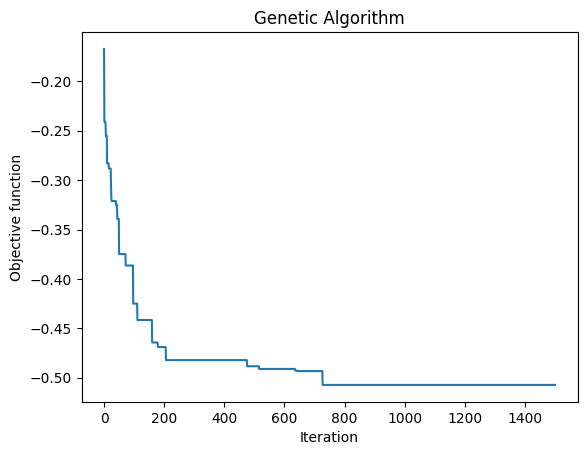

In [6]:
result = EQO_ga(M=relabus.T,y=group_m, pattern='d',maxIter=1500, popSize=100)